In [2]:
#Importing Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import streamlit as st
#First part data preperation
#Loading DataFrames
df_orders = pd.read_csv('olist_orders_dataset.csv')
df_items = pd.read_csv('olist_order_items_dataset.csv')
df_payments = pd.read_csv('olist_order_payments_dataset.csv')
df_products = pd.read_csv('olist_products_dataset.csv')
df_customers = pd.read_csv('olist_customers_dataset.csv')
df_category = pd.read_csv('product_category_name_translation.csv')

#Merging orders and customers (who bought what)
df_master = pd.merge(df_orders, df_customers, on = 'customer_id', how = 'inner')
#Merging price and product
df_master = pd.merge(df_master, df_items, on = 'order_id', how = 'inner')
#Merging payments
df_master = pd.merge(df_master, df_payments, on = 'order_id', how = 'inner')
#Mege with products
df_master = pd.merge(df_master, df_products[['product_id', 'product_category_name']], on='product_id', how='left')
#Merging with product category
df_master = pd.merge(df_master, df_category, on = 'product_category_name', how = 'left')

print(f"Final DataFrame shape: {df_master.shape}")


Final DataFrame shape: (117601, 24)


In [3]:
#Checking dataframe information
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117601 entries, 0 to 117600
Data columns (total 24 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       117601 non-null  object 
 1   customer_id                    117601 non-null  object 
 2   order_status                   117601 non-null  object 
 3   order_purchase_timestamp       117601 non-null  object 
 4   order_approved_at              117586 non-null  object 
 5   order_delivered_carrier_date   116356 non-null  object 
 6   order_delivered_customer_date  115034 non-null  object 
 7   order_estimated_delivery_date  117601 non-null  object 
 8   customer_unique_id             117601 non-null  object 
 9   customer_zip_code_prefix       117601 non-null  int64  
 10  customer_city                  117601 non-null  object 
 11  customer_state                 117601 non-null  object 
 12  order_item_id                 

In [4]:
#Convert necessary timestamp columns to datetime objects
timestamp_cols = [
    'order_purchase_timestamp',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]

for col in timestamp_cols:
    df_master[col] = pd.to_datetime(df_master[col], errors='coerce')

In [5]:
#Calculating the month of the first order for each customer "Cohort Month"
df_master['purchase_month'] = df_master['order_purchase_timestamp'].dt.to_period('M')

#Find month of first purchase for each customer ID
df_cohort = df_master.groupby('customer_unique_id')['order_purchase_timestamp'].min().dt.to_period('M') 
df_master['cohort_month'] = df_master['customer_unique_id'].map(df_cohort)

print(df_master[['order_purchase_timestamp', 'purchase_month', 'cohort_month']].tail())
#end of data preperation

       order_purchase_timestamp purchase_month cohort_month
117596      2018-02-06 12:58:58        2018-02      2018-02
117597      2017-08-27 14:46:43        2017-08      2017-08
117598      2018-01-08 21:28:27        2018-01      2018-01
117599      2018-01-08 21:28:27        2018-01      2018-01
117600      2018-03-08 20:57:30        2018-03      2018-03


In [6]:
#Using order_id to count unique orders
total_revenue = df_master['price'].sum()
total_orders = df_master['order_id'].nunique()
total_customers = df_master['customer_unique_id'].nunique()

#Calculating Average Order Value (AOV)
aov = total_revenue / total_orders

print(f"Total Revenue: R$ {total_revenue:,.2f}")
print(f"Total Orders: {total_orders:,}")
print(f"Total Unique Customers: {total_customers:,}")
print(f"Average Order Value (AOV): R$ {aov:,.2f}")

Total Revenue: R$ 14,209,115.34
Total Orders: 98,665
Total Unique Customers: 95,419
Average Order Value (AOV): R$ 144.01


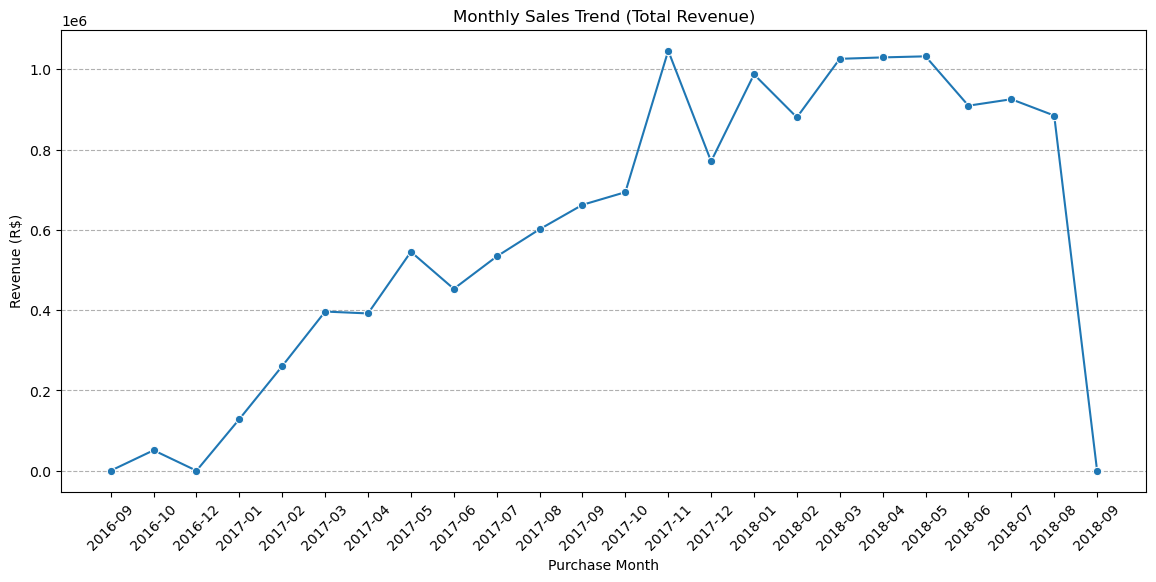


Monthly Revenue Table:
   purchase_month  Monthly Revenue  MoM Growth
19        2018-05       1032150.44    0.260147
20        2018-06        909221.10  -11.910022
21        2018-07        925302.46    1.768696
22        2018-08        884657.40   -4.392624
23        2018-09           145.00  -99.983609


In [7]:
#Group by the 'purchase-month'
monthly_revenue = df_master.groupby('purchase_month')['price'].sum().reset_index() 
monthly_revenue.rename(columns={'price': 'Monthly Revenue'}, inplace=True)
#Convert the 'purchase_month' Period object to a string (YYYY-MM)
monthly_revenue['purchase_month'] = monthly_revenue['purchase_month'].astype(str) 
#Creating Line Graph
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_revenue, x='purchase_month', y='Monthly Revenue', marker='o') 
plt.title('Monthly Sales Trend (Total Revenue)')
plt.xlabel('Purchase Month')
plt.ylabel('Revenue (R$)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.savefig('monthly_sales_trend.png')
plt.show()


monthly_revenue['MoM Growth'] = monthly_revenue['Monthly Revenue'].pct_change() * 100
print("\nMonthly Revenue Table:")
print(monthly_revenue.tail())


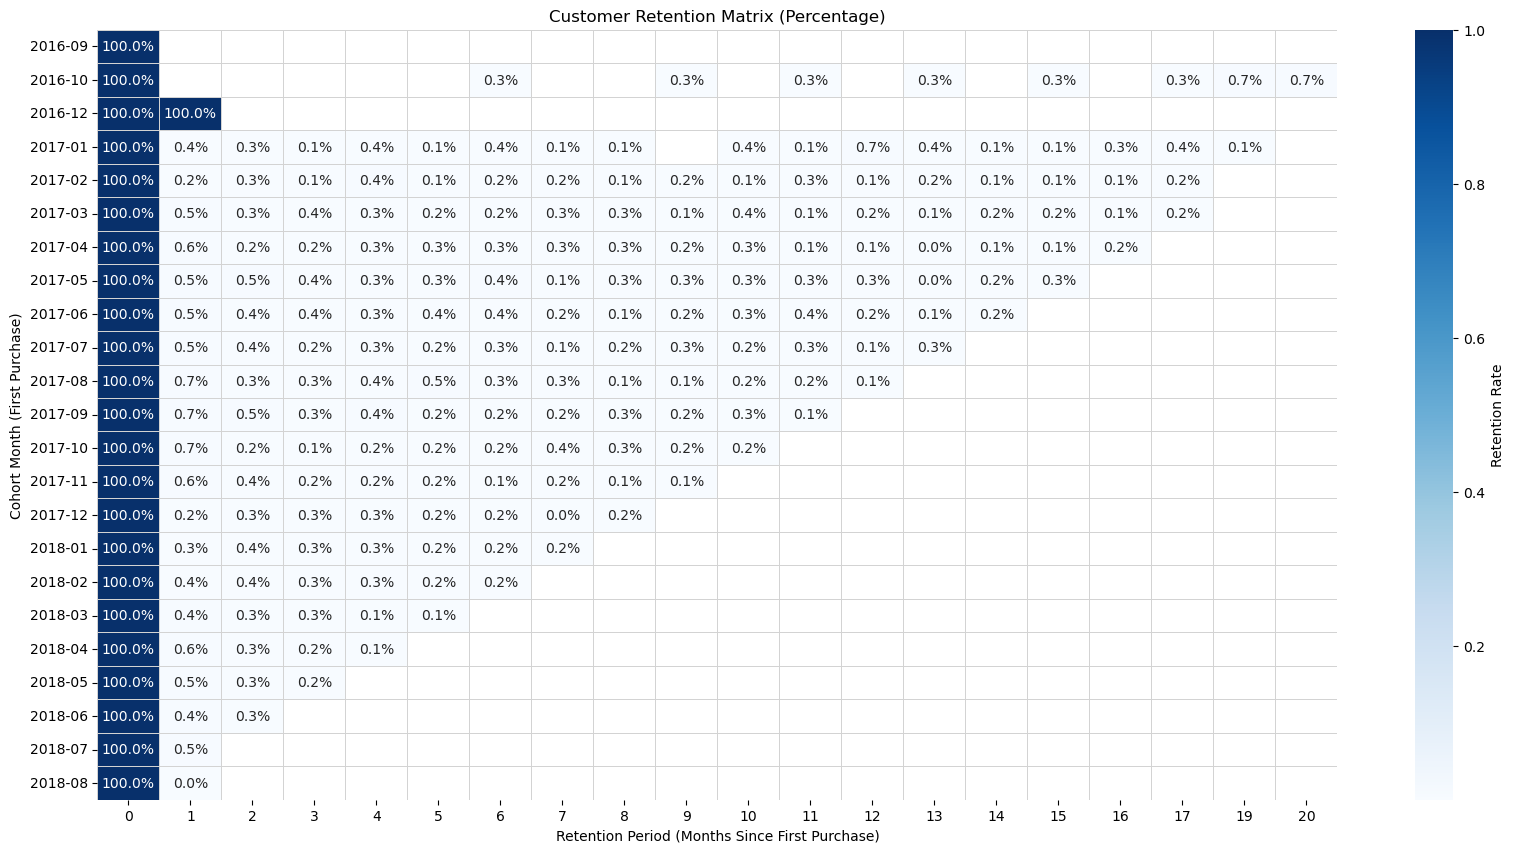

In [8]:
#Count the number of unique customers for each cohort month and period
cohort_counts = df_master.groupby(['cohort_month', 'purchase_month'])['customer_unique_id'].nunique().reset_index() 

#Assign the cohort period (Months since first purchase)
cohort_counts['CohortPeriod'] = (cohort_counts.purchase_month.dt.year * 12 + cohort_counts.purchase_month.dt.month) - \
                                 (cohort_counts.cohort_month.dt.year * 12 + cohort_counts.cohort_month.dt.month)
#Pivot the data to create retention table
cohort_pivot = cohort_counts.pivot_table(index='cohort_month',
                                         columns='CohortPeriod',
                                         values='customer_unique_id')

#Calculate Retention Rate dividing by the size of the initial cohort (Period 0)
cohort_sizes = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_sizes, axis=0)

#Testing retention rate
#print(retention_matrix.tail())
#print("\nMin value in matrix:", retention_matrix.min().min())
#print("Max value in matrix:", retention_matrix.max().max())

#To ensure no values are above 1.0/prevents data skewing
retention_matrix_clipped = retention_matrix.clip(upper=1.0)
#Visualization (Seaborn Heatmap)
plt.figure(figsize=(20, 10))
sns.heatmap(retention_matrix,
            annot=True,
            fmt='.1%',
            cmap='Blues',
            linewidths=0.5,
            linecolor='lightgray',
            vmax=1.0,
            vmin=0.0001,
            cbar_kws={'label': 'Retention Rate'})

plt.title('Customer Retention Matrix (Percentage)')
plt.ylabel('Cohort Month (First Purchase)')
plt.xlabel('Retention Period (Months Since First Purchase)')
plt.yticks(rotation=0)
plt.savefig('customer_retention_matrix.png')
plt.show()



/var/folders/tc/s8mngwjj08q9lbq01d9q0w7h0000gn/T/ipykernel_68023/4180772092.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_revenue, x='price', y='product_category_name_english', palette='viridis')


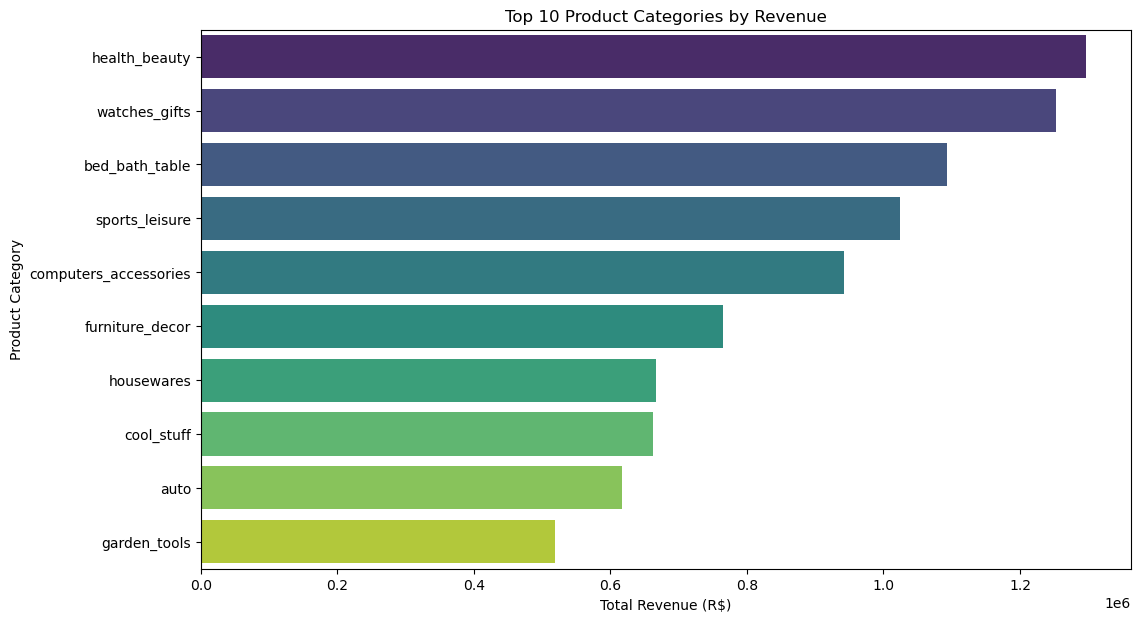

In [9]:
#Group by the English category name 
category_revenue = df_master.groupby('product_category_name_english')['price'].sum().nlargest(10).reset_index()

plt.figure(figsize=(12,7))
sns.barplot(data=category_revenue, x='price', y='product_category_name_english', palette='viridis')
plt.title('Top 10 Product Categories by Revenue')
plt.xlabel('Total Revenue (R$)')
plt.ylabel('Product Category')
plt.savefig('product_cat_revenue.png')
plt.show()

